# Zillow Prediction

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import arma_order_select_ic
from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn

import seaborn as sns
%matplotlib inline

from configs import *
from cp_utils import *
%load_ext autoreload
%autoreload 2

## 1. Exploratory Data Analysis

In [2]:
sep_date = '2015-12-31'
main_col = 'MedianSoldPrice_AllHomes.California'

In [3]:
# # purity train data, only keeping data before sep_date, after which is test data
# df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]
# df_train.to_csv("data/df_train_multi_cols.csv", index=True)
# df_train_one_col = df_train[main_col]
# df_train_one_col.to_csv("data/df_train_one_col.csv", index=True)

In [4]:
uni_df = pd.read_csv("data/df_train_one_col.csv", index_col=["Date"], parse_dates=["Date"])

In [5]:
uni_df.columns = ['price']

In [6]:
uni_df

,price
Date,
2008-02-29,470000.0
2008-03-31,441000.0
2008-04-30,460000.0
2008-05-31,429000.0
2008-06-30,437500.0
...,...
2015-08-31,475000.0
2015-09-30,470000.0
2015-10-31,470000.0


In [7]:
zillow = pd.read_csv('data/zillow-california.csv')

In [8]:
zillow

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2
...,...,...,...,...
102,2016-08-31,NaN,3.46,4.8
103,2016-09-30,NaN,3.42,5.0
104,2016-10-31,NaN,3.36,5.0
105,2016-11-30,NaN,3.47,4.8


In [9]:
multi_df = pd.read_csv('data/df_train_multi_cols.csv', index_col=['Date'], parse_dates=['Date'])

In [10]:
multi_df.columns = ['price','mortgage','unemployment']

### Original Data Plots

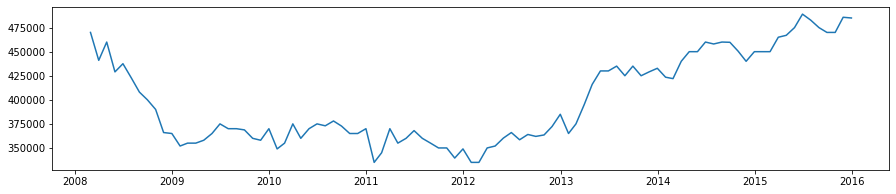

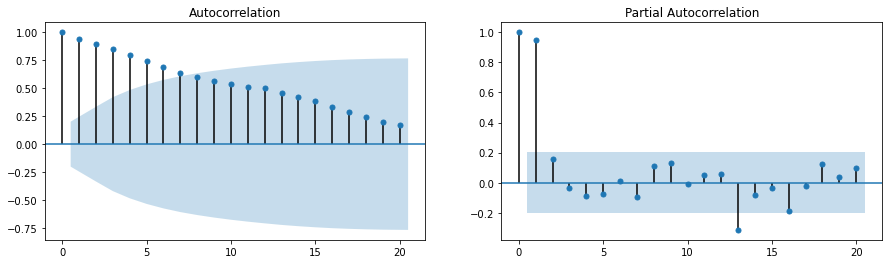

In [75]:
plot_all(uni_df, None)

# Candidate 1

### Detrend by 1
**Analysis**: According to the ADF test, the data has reached stationary from detrending by 1. Based on the ACF and PACF plot, there appears to be a seasonality component m=12. 


 Detrended by 1
Test Statistic   -3.088139
p-value           0.027443
dtype: float64


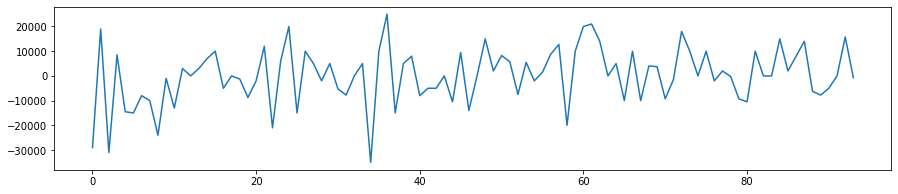

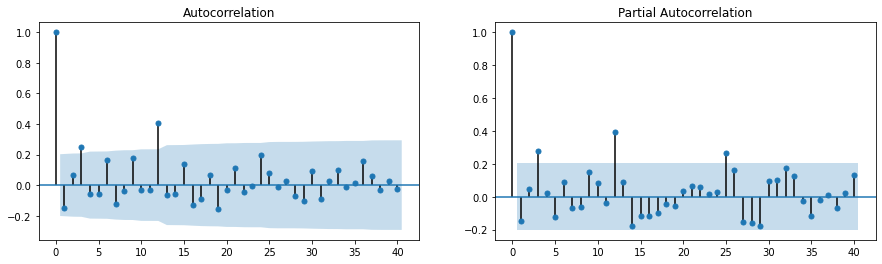

In [76]:
detrend1 = adf_plot_detrend(uni_df['price'], 1, False)
plot_all(detrend1, 40)

### Seasonality m=12


 Detrended by 12
Test Statistic   -8.786215e+00
p-value           2.304893e-14
dtype: float64


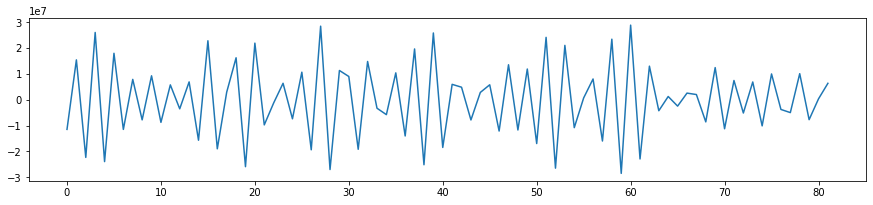

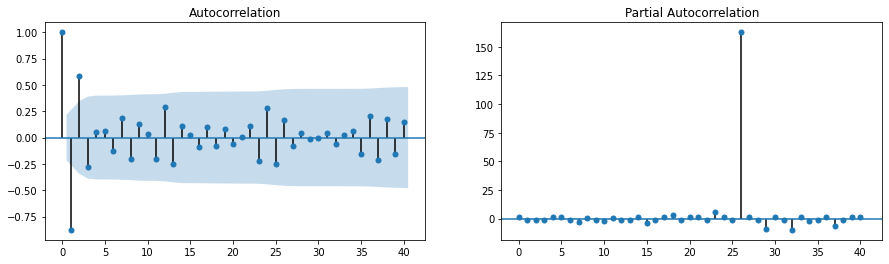

In [77]:
deseason1 = adf_plot_detrend(detrend1, 12, False)
plot_all(deseason1, 40)

#### **Candidate  Model 1**: SARIMA(2,1,1)(0,1,2,12)

In [84]:
bic_sarima(uni_df['price'], [0,1,2], [1], [0,1,2], [0], [1], [2], [12]) 

(691.7971582754187, (2, 1, 1), (0, 1, 2, 12))


In [841]:
print(f"MAPE Candidate 1: {mape_sarima(uni_df['price'].tolist(), (2, 1, 1), (0, 1, 2, 12), 0.80)}")
print(f"MAE Candidate 1: {mae_sarima(uni_df['price'].tolist(), (2,1,1), (0,1,2,12), 0.80)}")
print(f"RMSE Candidate 1: {rmse_sarima(uni_df['price'].tolist(), (2,1,1), (0,1,2,12), 0.80)}")

MAPE Candidate 1: 0.01815093894756603
MAE Candidate 1: 8345.528595499703
RMSE Candidate 1: 9774.44701772535


# Candidate 2 and 3

### Detrend by 2
**Analysis**: According to the ADF test, the data has reached stationary from detrending by 1. Based on the ACF and PACF plot, there appears to be a seasonality component m=26


 Detrended by 2
Test Statistic   -7.390432e+00
p-value           8.027576e-11
dtype: float64


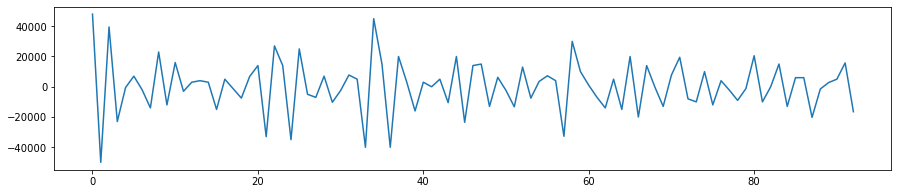

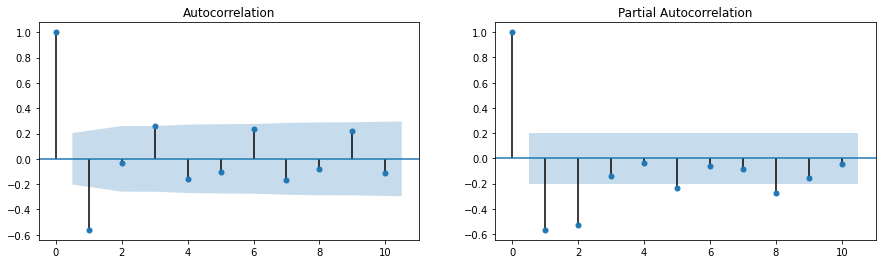

In [ ]:
detrend2 = adf_plot_detrend(uni_df['price'], 2, False)
plot_all(detrend2, 10)

In [ ]:
#MA = 1, AR = 2


 Detrended by 12
Test Statistic   -8.789198e+00
p-value           2.264700e-14
dtype: float64


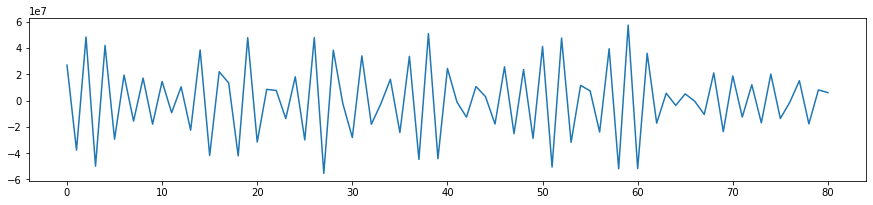

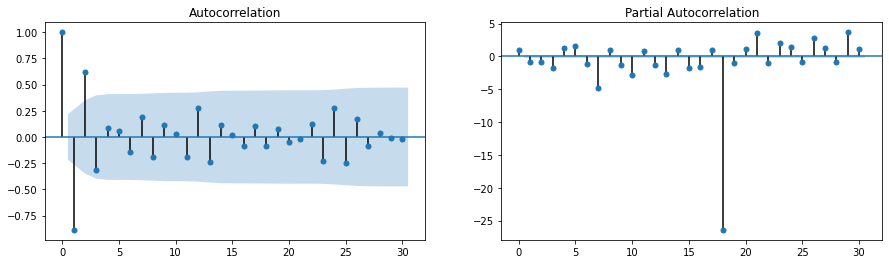

In [ ]:
deseason2 = adf_plot_detrend(detrend2, 12, False)
plot_all(deseason2, 30)

#### **Candidate  Model 2**: SARIMA(2,2,1)(0,1,2,12)

In [ ]:
print(f"MAPE Candidate 2: {mape_sarima(uni_df['price'].tolist(), (2,2,1), (0,1,2,12), 0.80)}")
print(f"MAE Candidate 2: {mae_sarima(uni_df['price'].tolist(), (2,2,1), (0,1,2,12), 0.80)}")
print(f"RMSE Candidate 2: {rmse_sarima(uni_df['price'].tolist(), (2,2,1), (0,1,2,12), 0.80)}")

MAPE Candidate 2: 0.020053850267653883
MAE Candidate 2: 9360.40506051038
RMSE Candidate 2: 11105.348713497071


#### **Candidate  Model 3**: SARIMA(2,2,1)(0,0,0,0)

In [ ]:
print(f"MAPE Candidate 3: {mape_sarima(uni_df['price'].tolist(), (2,2,1),(0,0,0,0), 0.80)}")
print(f"MAE Candidate 3: {mae_sarima(uni_df['price'].tolist(), (2,2,1),(0,0,0,0), 0.80)}")
print(f"RMSE Candidate 3: {rmse_sarima(uni_df['price'].tolist(), (2,2,1),(0,0,0,0), 0.80)}")

MAPE Candidate 3: 0.018899511105572076
MAE Candidate 3: 8839.09698442295
RMSE Candidate 3: 10714.086139703124


# Candidate 4: ETS

In [842]:
X=np.array(uni_df['price'])+1 #adding 1 to avoide 0 sales 

In [843]:
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=12,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=12,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=12,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=12,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=12,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=12,damped=False)

In [844]:
print(mape_1)
print(mape_2) #didn't seem to converge
print(mape_3)
print(mape_4)
print(mape_5)
print(mape_6)

0.021445197648976785
3.7013058943556963e+40
0.03007538318280542
4.672825324158227e+46
0.019466950087257455
0.022464922747028698


#### **Candidate  Model 4**: ETS
Trend = None, Seasonal = Additive, m =12

In [845]:
print(f"MAPE Candidate 4: {evaluate_es_model_mape(X, Trend=None, Seasonal='additive',m=12,damped=False)}")
print(f"MAE Candidate 4: {mae_ETS(X, None, 'additive', 12, False, 0.80) }")
print(f"RMSE Candidate 4: {rmse_ETS(X, None, 'additive', 12, False, 0.80) }")

MAPE Candidate 4: 0.019466950087257455
MAE Candidate 4: 8125.710249911243
RMSE Candidate 4: 10385.301142457134


# Candidate 5: Prophet

In [ ]:
uni_df2 = pd.read_csv("data/df_train_one_col.csv")
uni_df2.columns = ['ds', 'y']

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'changepoint_prior_scale':[0.021, 0.022, 0.023],
               'seasonality_prior_scale':[8,9,10],
               'yearly_seasonality': [True,False],
               'weekly_seasonality': [False],
               'daily_seasonality': [False]}

grid = ParameterGrid(params_grid)

In [ ]:
len(uni_df2)*.80 

76.0

In [ ]:
train_proph = uni_df2[:76]
test_prophet=uni_df2[77:]

all_mape = []
for p in grid:
    model = Prophet(**p)
    model.fit(train_proph)

    future = model.make_future_dataframe(periods=19, freq='M')
    yhat = model.predict(future)

    y_pred = yhat[77:]['yhat'].tolist()
    y_actual = test_prophet['y'].tolist()
    all_mape.append((p, mean_absolute_percentage_error(y_actual, y_pred)))

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
all_prophets = (sorted(all_mape, key = lambda x: x[1])) 

In [ ]:
all_prophets[0]

({'changepoint_prior_scale': 0.021,
  'daily_seasonality': False,
  'seasonality_prior_scale': 8,
  'weekly_seasonality': False,
  'yearly_seasonality': False},
 0.01789615046506783)

In [ ]:
model = Prophet(daily_seasonality=False, 
            weekly_seasonality=False,
            yearly_seasonality=False,
            changepoint_prior_scale=0.0219,
            seasonality_prior_scale = 8,
            n_changepoints = 12)
model.fit(train_proph)

future = model.make_future_dataframe(periods=19, freq='M')
yhat = model.predict(future)
y_pred = yhat[77:]['yhat'].tolist()
y_actual = test_prophet['y'].tolist()

### Univariate Prophet Metrics

In [ ]:
print(f"MAPE Candidate 5: {mean_absolute_percentage_error(y_actual, y_pred)}")
print(f"MAE Candidate 5: {mean_absolute_error(y_actual, y_pred)}")
print(f"RMSE Candidate 5: {sqrt(mean_squared_error(y_actual, y_pred))}")

Univariate Prophet
MAPE Candidate 5: 0.017878969223119295
MAE Candidate 5: 8314.93596583012
RMSE Candidate 5: 10266.578192752495


# Candidate 6: SARIMAX

In [ ]:
train_size = int(len(multi_df.iloc[:,0]) * 0.80)
train, val = multi_df.iloc[:,0][0:train_size], multi_df.iloc[:,0][train_size:]

exog = multi_df.iloc[:,1:]
exog_train = exog[0:train_size]
exog_test = exog[train_size:]

predictions = list()

In [ ]:
model = sm.tsa.statespace.SARIMAX(train, exog=exog_train, order=(1,1,0),seasonal_order=(0,1,2,12))
res = model.fit()
yhat = res.predict(start=len(train), end=len(train)+len(val)-1, exog=exog_test) #predict one step
y_pred = yhat.tolist()
mean_absolute_percentage_error(val.values, y_pred)

0.022525832080218675

In [ ]:
print(f"MAPE Candidate 5: {mean_absolute_percentage_error(val.values, y_pred)}")
print(f"MAE Candidate 5: {mean_absolute_error(val.values, y_pred)}")
print(f"RMSE Candidate 5: {sqrt(mean_squared_error(val.values, y_pred))}")

MAPE Candidate 5: 0.022525832080218675
MAE Candidate 5: 10471.170220533664
RMSE Candidate 5: 12575.044083848521


# Candidate 7: Multivariate Prophet

#### **Candidate  Model 4**: Prophet

In [11]:
uni_df2 = pd.read_csv("data/df_train_one_col.csv")
uni_df2.columns = ['ds', 'y']

In [12]:
multi_df2 = pd.read_csv('data/df_train_multi_cols.csv')

In [13]:
multi_df2.columns = ['ds','y','mortgage','unemployment']

In [14]:
train_proph = multi_df2[:76]
test_prophet= multi_df2[77:]

In [38]:
model = Prophet(daily_seasonality=True, 
            weekly_seasonality=False,
            yearly_seasonality=False,
            n_changepoints=40,
            changepoint_prior_scale=0.025,
            seasonality_prior_scale=10)

model.add_regressor('mortgage')
model.add_regressor('unemployment')
model.fit(train_proph)

yhat = model.predict(test_prophet.drop(columns='y'))['yhat'].tolist()

y_actual = test_prophet['y'].tolist()
mean_absolute_percentage_error(y_actual, yhat)

0.01883666983231173

In [16]:
np.sqrt(mean_squared_error(y_actual, yhat))

11037.64385870684

# Candidate 8: LTSM

In [39]:
from LSTM import * 
all_data = multi_df['price'].values.astype(float)
all_data[:6]

array([470000., 441000., 460000., 429000., 437500., 423000.])

In [40]:
test_data_size = 18

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [41]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [42]:
print(train_data_normalized[:5])

[[1.        ]
 [0.57037037]
 [0.85185185]
 [0.39259259]
 [0.51851852]]


In [43]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [44]:
train_window = 18
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[(tensor([ 1.0000,  0.5704,  0.8519,  0.3926,  0.5185,  0.3037,  0.0815, -0.0370,
          -0.1852, -0.5407, -0.5556, -0.7481, -0.7037, -0.7037, -0.6593, -0.5556,
          -0.4074, -0.4815]),
  tensor([-0.4815])),
 (tensor([ 0.5704,  0.8519,  0.3926,  0.5185,  0.3037,  0.0815, -0.0370, -0.1852,
          -0.5407, -0.5556, -0.7481, -0.7037, -0.7037, -0.6593, -0.5556, -0.4074,
          -0.4815, -0.4815]),
  tensor([-0.5000])),
 (tensor([ 0.8519,  0.3926,  0.5185,  0.3037,  0.0815, -0.0370, -0.1852, -0.5407,
          -0.5556, -0.7481, -0.7037, -0.7037, -0.6593, -0.5556, -0.4074, -0.4815,
          -0.4815, -0.5000]),
  tensor([-0.6296])),
 (tensor([ 0.3926,  0.5185,  0.3037,  0.0815, -0.0370, -0.1852, -0.5407, -0.5556,
          -0.7481, -0.7037, -0.7037, -0.6593, -0.5556, -0.4074, -0.4815, -0.4815,
          -0.5000, -0.6296]),
  tensor([-0.6593])),
 (tensor([ 0.5185,  0.3037,  0.0815, -0.0370, -0.1852, -0.5407, -0.5556, -0.7481,
          -0.7037, -0.7037, -0.6593, -0.5556, -0.4074,

In [45]:
len(train_inout_seq)

59

In [46]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
print(model)

LSTM(
  (lstm): LSTM(1, 40)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)


In [ ]:
path_dir = '/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/'
epochs = 50
train(model, optimizer, epochs, train_inout_seq, loss_function, 'model4', path_dir)

epoch:   1 loss: 0.86562908
epoch:  26 loss: 0.01673446
epoch:  49 loss: 0.0005770299


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model4'))
train(model, optimizer, epochs, train_inout_seq, loss_function, 'model5', path_dir)

epoch:   1 loss: 0.00531610
epoch:  26 loss: 0.01456780
epoch:  51 loss: 0.00055182
epoch:  76 loss: 0.00179339
epoch: 101 loss: 0.00119004
epoch: 126 loss: 0.00030618
epoch: 149 loss: 0.0026102797


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model5'))
train(model, optimizer, epochs, train_inout_seq, loss_function, 'model6', path_dir)

epoch:   1 loss: 0.00172489
epoch:  26 loss: 0.00061409
epoch:  51 loss: 0.00044267
epoch:  76 loss: 0.00038879
epoch: 101 loss: 0.00031136
epoch: 126 loss: 0.00020261
epoch: 149 loss: 0.0001147858


In [48]:
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model4'))

<All keys matched successfully>

In [49]:
fut_pred = 18

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.5555555820465088, -0.40740740299224854, -0.1111111119389534, 0.20000000298023224, 0.40740740299224854, 0.40740740299224854, 0.48148149251937866, 0.3333333432674408, 0.48148149251937866, 0.3333333432674408, 0.39259257912635803, 0.4481481611728668, 0.31111112236976624, 0.2888889014720917, 0.5555555820465088, 0.7037037014961243, 0.7037037014961243, 0.8518518805503845]


In [50]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [51]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[466428.22295427]
 [471612.08540201]
 [473972.82093763]
 [474597.40012884]
 [473860.19229889]
 [472164.58290815]
 [469962.99356222]
 [467741.88309908]
 [465910.00407934]
 [464839.49288726]
 [464671.72473669]
 [465436.15430593]
 [467007.83759356]
 [469047.67364264]
 [471252.95639038]
 [473419.4624424 ]
 [475304.71473932]
 [476677.80727148]]


In [52]:
y_actual = test_data.tolist()

In [53]:
y_preds = actual_predictions.reshape(1,18)[0].tolist()

In [54]:
mean_absolute_percentage_error(y_actual, y_preds)

0.02824054582154641

In [56]:
np.sqrt(mean_squared_error(y_actual,y_preds))

15780.122942472899

# Forecasting
### ETS Test Forecasting

In [ ]:
test_df =pd.read_csv('data/test.csv', index_col=["Month"], parse_dates=["Month"])

In [ ]:
test_df.columns = ['price']

In [ ]:
model_ets=ExponentialSmoothing(uni_df['price'], 
                               trend=None, 
                               seasonal="additive", 
                               damped=False, 
                               seasonal_periods=12)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test_df))
pred_ets.index=test_df.index

In [ ]:
test_df['pred_price'] = pd.Series(pred_ets, index=test_df.index)

In [ ]:
def plot_hist_pred(history, test, pred):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    time = [history['price'], history['price']['2013-10-01':]]
    titles = ['All Data', 'Shortened']
    for i in range(2):
        ax[i].plot(time[i], label='Median Temperature')
        ax[i].plot(test['price'],label='Actual Price')
        ax[i].plot(test[pred],label='Predicted Price')
        ax[i].legend(loc='upper left', fontsize=8)
        ax[i].set_title(titles[i])

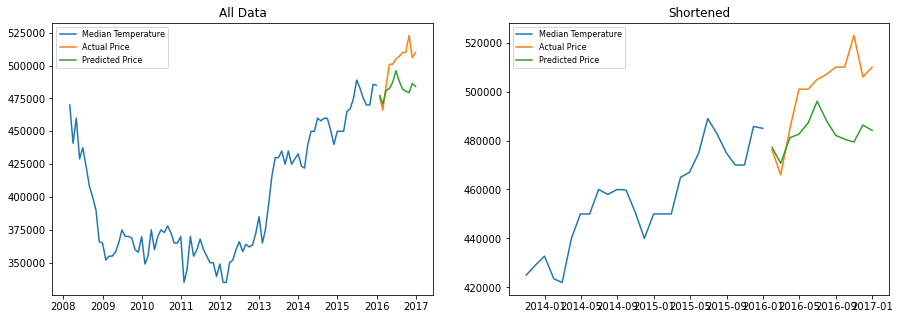

In [ ]:
plot_hist_pred(uni_df, test_df, 'pred_price')

In [ ]:
y_actual = test_df['price'].tolist()

In [ ]:
preds = pred_ets.tolist()

In [ ]:
def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred = np.array(pred)
    return np.sum(np.abs(actual - pred)/actual)/len(actual)

In [ ]:
print(f'MAPE: {mean_absolute_percentage_error(y_actual, preds)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_actual,preds))}')

MAPE: 0.03536583966506937
RMSE: 21605.851304793516


## Univariate Prophet Forecasting

In [ ]:
history=pd.read_csv('data/df_train_one_col.csv')
history.columns = ['ds','y']

test =pd.read_csv('data/test.csv')
test.columns = ['ds','y']


m = Prophet(daily_seasonality=False, 
            weekly_seasonality=False,
            yearly_seasonality=False,
            changepoint_prior_scale=0.0219,
            seasonality_prior_scale = 10,
            n_changepoints = 12)

m.fit(history)


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
test =pd.read_csv('data/test.csv', index_col=["Month"], parse_dates=["Month"])
test.columns = ['price']

In [ ]:
future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)
pred = forecast[-(len(test)):]['yhat'].tolist()
test['pred_price'] = pd.Series(pred, index=test.index)

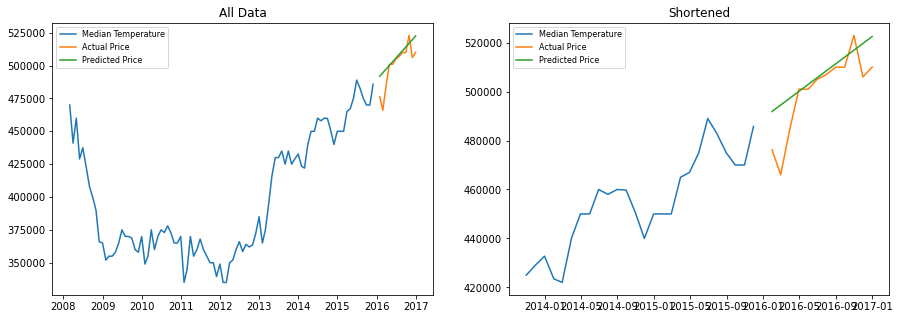

In [ ]:
history = uni_df[:'2015-11-30'][['price']]
plot_hist_pred(history, test, 'pred_price')
actual_test = test['price'].tolist()

In [ ]:
def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred = np.array(pred)
    return np.sum(np.abs(actual - pred)/actual)/len(actual)

In [ ]:
print(f'MAPE: {mean_absolute_percentage_error(actual_test, pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(actual_test, pred))}')

MAPE: 0.01694558481278248
RMSE: 11607.763440662453


## Multivariate Prophet Forecasting

In [ ]:
multi_df2 = pd.read_csv("data/df_train_multi_cols.csv")
multi_df2.columns = ['ds', 'y', 'mortgage', 'unemployment']

In [ ]:
test_prices = pd.read_csv('data/test.csv')
test = zillow[zillow['Date'] >= '2016-01-31']
test['y'] = test_prices['Median House Price'].tolist()
test = test.drop(columns=['MedianSoldPrice_AllHomes.California'])
test.columns=['ds','mortgage','unemployment', 'y']

In [ ]:
model = Prophet(daily_seasonality=True, 
            weekly_seasonality=False,
            yearly_seasonality=False,
            n_changepoints=40,
            changepoint_prior_scale=0.025,
            seasonality_prior_scale=10)

model.add_regressor('mortgage')
model.add_regressor('unemployment')
model.fit(multi_df2)

yhat = model.predict(test.drop(columns='y'))['yhat'].tolist()

y_actual = test['y'].tolist()

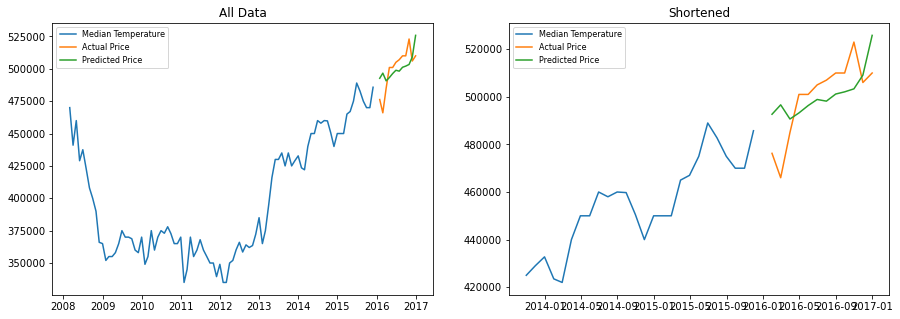

In [ ]:
test_df['pred_price'] = yhat
history = uni_df[:'2015-11-30'][['price']]
plot_hist_pred(history, test_df, 'pred_price')
actual_test = test['price'].tolist()

In [ ]:
print(f'MAPE: {mean_absolute_percentage_error(y_actual, yhat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_actual, yhat))}')

MAPE: 0.02282477997161006
RMSE: 13615.852903559095


## LSTM Forecasting

In [ ]:
from LSTM import * 

In [ ]:
all_data = multi_df['price'].values.astype(float)
all_data

array([470000., 441000., 460000., 429000., 437500., 423000., 408000.,
       400000., 390000., 366000., 365000., 352000., 355000., 355000.,
       358000., 365000., 375000., 370000., 370000., 368750., 360000.,
       358000., 370000., 349000., 355000., 375000., 360000., 370000.,
       375000., 373000., 378000., 372750., 365000., 365000., 370000.,
       335000., 345000., 370000., 355000., 360000., 368000., 360000.,
       355000., 350000., 350000., 339500., 349000., 335000., 335000.,
       350000., 352000., 360250., 366000., 358500., 364000., 362000.,
       363500., 372250., 385000., 365000., 375000., 395000., 416000.,
       430000., 430000., 435000., 425000., 435000., 425000., 429000.,
       432750., 423500., 422000., 440000., 450000., 450000., 460000.,
       458000., 460000., 459750., 450500., 440000., 450000., 450000.,
       450000., 465000., 467000., 475000., 489000., 482750., 475000.,
       470000., 470000., 485750., 485000.])

#### Normalizing Target

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(all_data .reshape(-1, 1))

In [ ]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.75324675]
 [0.37662338]
 [0.62337662]
 [0.22077922]
 [0.33116883]]
[[0.81818182]
 [0.75324675]
 [0.75324675]
 [0.95779221]
 [0.94805195]]


In [ ]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

#### Creating Price Sequences of 12

In [ ]:
train_window = 12

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [ ]:
train_inout_seq[:6]

[(tensor([ 0.7532,  0.3766,  0.6234,  0.2208,  0.3312,  0.1429, -0.0519, -0.1558,
          -0.2857, -0.5974, -0.6104, -0.7792]),
  tensor([-0.7403])),
 (tensor([ 0.3766,  0.6234,  0.2208,  0.3312,  0.1429, -0.0519, -0.1558, -0.2857,
          -0.5974, -0.6104, -0.7792, -0.7403]),
  tensor([-0.7403])),
 (tensor([ 0.6234,  0.2208,  0.3312,  0.1429, -0.0519, -0.1558, -0.2857, -0.5974,
          -0.6104, -0.7792, -0.7403, -0.7403]),
  tensor([-0.7013])),
 (tensor([ 0.2208,  0.3312,  0.1429, -0.0519, -0.1558, -0.2857, -0.5974, -0.6104,
          -0.7792, -0.7403, -0.7403, -0.7013]),
  tensor([-0.6104])),
 (tensor([ 0.3312,  0.1429, -0.0519, -0.1558, -0.2857, -0.5974, -0.6104, -0.7792,
          -0.7403, -0.7403, -0.7013, -0.6104]),
  tensor([-0.4805])),
 (tensor([ 0.1429, -0.0519, -0.1558, -0.2857, -0.5974, -0.6104, -0.7792, -0.7403,
          -0.7403, -0.7013, -0.6104, -0.4805]),
  tensor([-0.5455]))]

In [ ]:
len(train_inout_seq)

83

#### Defining Model, Loss Function and Optimizer

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

LSTM(
  (lstm): LSTM(1, 40)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)


#### Training

In [ ]:
epochs = 150
path_dir = '/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/'
train(model, optimizer, train_inout_seq, loss_function, 'model1', path_dir)

epoch:   1 loss: 0.35099193
epoch:  26 loss: 0.00344615
epoch:  51 loss: 0.00001086
epoch:  76 loss: 0.00444564
epoch: 101 loss: 0.00330741
epoch: 126 loss: 0.00016946
epoch: 149 loss: 0.0010817418


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model1'))
train(model, optimizer, train_inout_seq, loss_function, 'model2', path_dir)

epoch:   1 loss: 0.00400384
epoch:  26 loss: 0.00259938
epoch:  51 loss: 0.00187747
epoch:  76 loss: 0.00008111
epoch: 101 loss: 0.00000235
epoch: 126 loss: 0.00246366
epoch: 149 loss: 0.0006967318


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model2'))
train(model, optimizer, train_inout_seq, loss_function, 'model3', path_dir)

epoch:   1 loss: 0.00071639
epoch:  26 loss: 0.00053303
epoch:  51 loss: 0.00060905
epoch:  76 loss: 0.00080787
epoch: 101 loss: 0.00435028
epoch: 126 loss: 0.00010112
epoch: 149 loss: 0.0022993882


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model3'))
train(model, optimizer, train_inout_seq, loss_function, 'model4', path_dir)

epoch:   1 loss: 0.00056765
epoch:  26 loss: 0.00001609
epoch:  51 loss: 0.00000170
epoch:  76 loss: 0.00000004
epoch: 101 loss: 0.00008267
epoch: 126 loss: 0.00003354
epoch: 149 loss: 0.0000209422


In [ ]:
model.load_state_dict(torch.load(f'/classes/Spring/TimeSeries_604/2021-02-19_Time_Series_Final_Project/models/model1'))

<All keys matched successfully>

In [ ]:
fut_pred = 12

test_inputs = train_data_normalized[-fut_pred:].tolist()
print(test_inputs)

[0.4935064911842346, 0.4935064911842346, 0.6883116960525513, 0.7142857313156128, 0.8181818127632141, 1.0, 0.9188311696052551, 0.8181818127632141, 0.7532467246055603, 0.7532467246055603, 0.9577922224998474, 0.948051929473877]


In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[fut_pred:] ).reshape(-1, 1))
y_actual = test_df['price'].tolist()
y_preds = actual_predictions.reshape(1,12)[0].tolist()

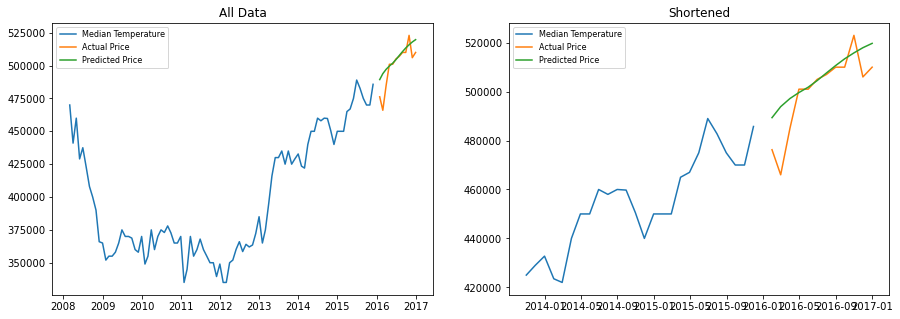

In [ ]:
test_df['pred_price'] = y_preds
history = uni_df[:'2015-11-30'][['price']]
plot_hist_pred(history, test_df, 'pred_price')
actual_test = test_df['price'].tolist()

In [ ]:
print(f'MAPE: {mean_absolute_percentage_error(y_actual, y_preds)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_actual, y_preds))}')

MAPE: 0.01527918768828184
RMSE: 10801.655777734013


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0aaa1fc-5db0-4bb5-b9fc-a59427928618' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [57]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from utils import *
from fbprophet import *
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import *

In [58]:
def mean_absolute_error(test,pred):
    test=np.array(test)
    pred=np.array(pred)
    return np.mean(np.abs(test-pred)/np.abs(test))

## 1. Exploratory Data Analysis

In [59]:
sep_date = '2015-12-31'
main_col = 'MedianSoldPrice_AllHomes.California'

In [60]:
# # purity train data, only keeping data before sep_date, after which is test data
df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]
df_test=pd.read_csv("data/test.csv",index_col=["Month"], parse_dates=["Month"])
# df_train.to_csv("data/df_train_multi_cols.csv", index=True)
# df_train_one_col = df_train[main_col]
# df_train_one_col.to_csv("data/df_train_one_col.csv", index=True)

In [61]:
df_train_one_col = pd.read_csv("data/df_train_one_col.csv", index_col=["Date"], parse_dates=["Date"])
data = df_train_one_col[main_col].values

In [62]:
df_train.head(5)

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


### 1.1 Time Series Plot

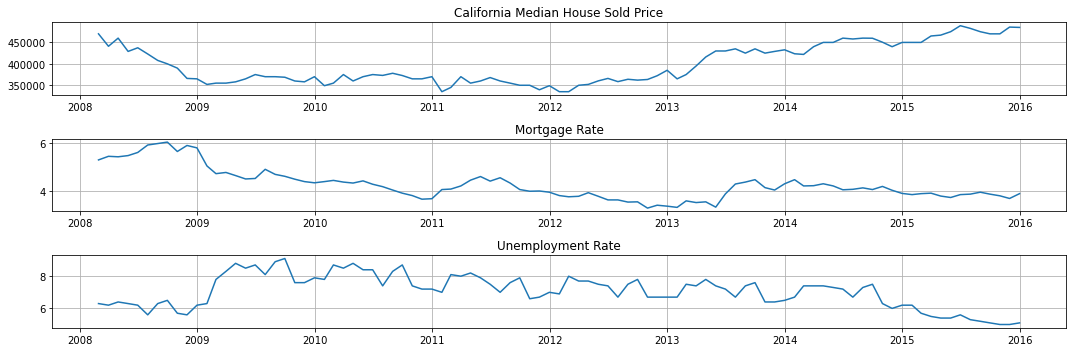

In [63]:
fig, ax = plt.subplots(3,1,figsize=(15,5))
ax[0].plot(df_train_one_col)
#ax.plot(df_train.MedianMortageRate)
ax[0].set_title("California Median House Sold Price")
ax[0].grid()
ax[1].plot(df_train.MedianMortageRate)
ax[1].grid()
ax[1].set_title("Mortgage Rate")
ax[2].plot(df_train['UnemploymentRate'])
ax[2].set_title("Unemployment Rate")
ax[2].grid()

plt.tight_layout()
plt.show()

- From time series plot, we could see that the median sold price keeps dropping since 2008 until it reaches the lowest point near 2012. Then the median sold price keeps going up.
- We can see that with increase in unemployment, there is a drop in mortgage price and the median price of california
- When mortgage rate drops there is an increase in Median House Sold Price in California

### 1.1 Time Series Plot with Smoothing

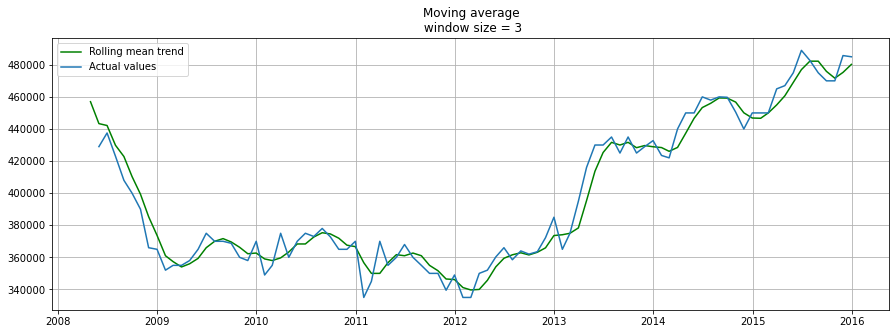

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
plot_moving_average(df_train_one_col, 3, ax=ax, plot_actual=True) 
plt.show()

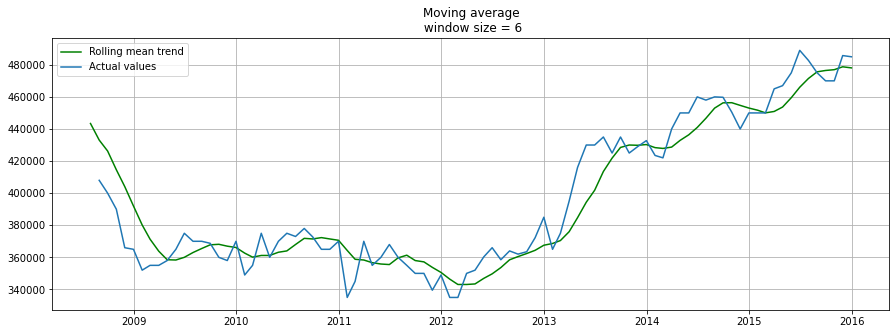

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
plot_moving_average(df_train_one_col, 6, ax=ax, plot_actual=True) 
plt.show()

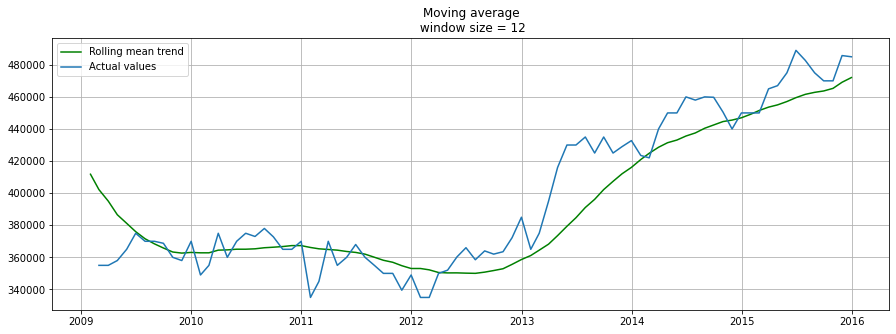

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
plot_moving_average(df_train_one_col, 12, ax=ax, plot_actual=True) 
plt.show()

### 1.1 ACF Plot

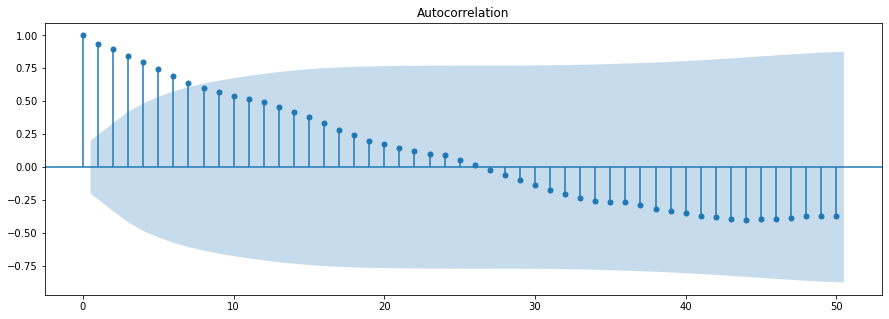

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
plot_acf(data, lags=50, ax=ax)
plt.show()

- From ACF Plot we could see that the data has good trending.

### 1.1 PACF Plot

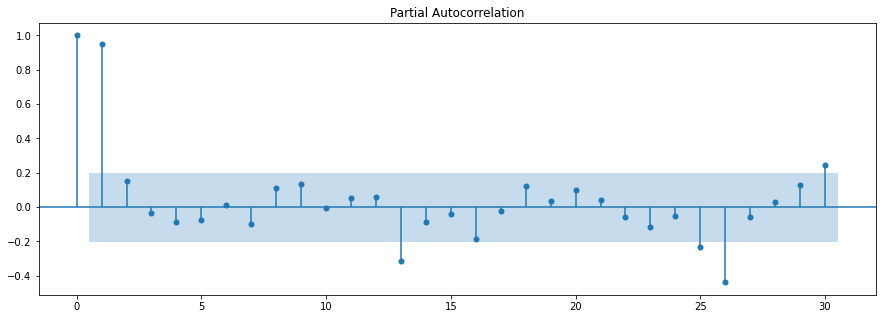

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
plot_pacf(data, lags=30, ax=ax)
plt.show()

- The PACF Plot shuts-off around lag=2, it might be an AR process with p=2

## 2. Train Multivariate Models

### 2.1 Vector Autoregressive Model

In [758]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [774]:
df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]
df_train.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [775]:
train_size = int(len(df_train.iloc[:,0]) * 0.90)
df_train, test_final = df_train[0:train_size], df_train[train_size:]

In [776]:
test_final.shape

(10, 3)

In [777]:
dftest1 = adfuller(df_train['MedianSoldPrice_AllHomes.California'], autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(df_train['MedianMortageRate'], autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(df_train['UnemploymentRate'], autolag='AIC')
dfoutput3 = pd.Series(dftest3[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -0.397331
p-value           0.910543
dtype: float64
Test Statistic   -1.691501
p-value           0.435497
dtype: float64
Test Statistic   -1.805812
p-value           0.377580
dtype: float64


## Testing for Granger's Causality Test

In [778]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'

In [779]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df    

In [780]:
grangers_causation_matrix(df_train, variables = df_train.columns)  

,MedianSoldPrice_AllHomes.California_x,MedianMortageRate_x,UnemploymentRate_x
MedianSoldPrice_AllHomes.California_y,1.0000,0.0,0.0000
MedianMortageRate_y,0.0345,1.0,0.0752
UnemploymentRate_y,0.0000,0.0,1.0000


### Maybe after differencing the values there will be more causality? 
### Conclusion: There is causality since p value <0.05

In [781]:
train=df_train.diff().diff().dropna()

In [782]:
grangers_causation_matrix(train, variables = train.columns)  

,MedianSoldPrice_AllHomes.California_x,MedianMortageRate_x,UnemploymentRate_x
MedianSoldPrice_AllHomes.California_y,1.0000,0.0002,0.0000
MedianMortageRate_y,0.0003,1.0000,0.0308
UnemploymentRate_y,0.0000,0.0005,1.0000


In [783]:
dt_diff=train

In [784]:
dftest1 = adfuller(dt_diff['MedianSoldPrice_AllHomes.California'], autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(dt_diff['MedianMortageRate'], autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(dt_diff['UnemploymentRate'], autolag='AIC')
dfoutput3 = pd.Series(dftest3[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -6.823280e+00
p-value           1.976894e-09
dtype: float64
Test Statistic   -5.001469
p-value           0.000022
dtype: float64
Test Statistic   -1.335966e+01
p-value           5.459868e-25
dtype: float64


In [785]:
standard_scaler=MinMaxScaler(feature_range=(0,1))
standard_scaler.fit(dt_diff)
dt_standard=standard_scaler.transform(dt_diff)

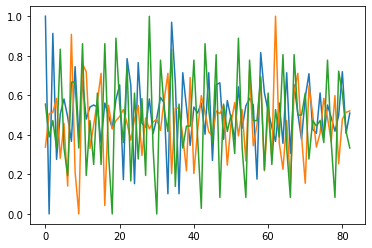

In [786]:
plt.plot(dt_standard)

In [787]:
# model fitting on the differenced data, auto choose AR order
from statsmodels.tsa.api import VAR
model = VAR(dt_standard)
model_select = model.select_order(maxlags=15)
model_select.summary()

,AIC,BIC,FPE,HQIC
0,-10.00,-9.906,4.524e-05,-9.965
1,-10.66,-10.27,2.349e-05,-10.50
2,-11.40,-10.72*,1.118e-05,-11.13
3,-11.53,-10.56,9.849e-06,-11.15
4,-11.99,-10.72,6.291e-06,-11.49
5,-12.25,-10.68,4.924e-06,-11.63
6,-12.40,-10.54,4.302e-06,-11.67
7,-12.42,-10.26,4.358e-06,-11.56
8,-12.82,-10.37,3.027e-06,-11.85
9,-12.73,-9.985,3.472e-06,-11.64


In [788]:
var_model=model.fit(maxlags=15,ic='fpe')
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Mar, 2021
Time:                     16:17:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.1895
Nobs:                     71.0000    HQIC:                  -12.3202
Log likelihood:           296.071    FPE:                1.53599e-06
AIC:                     -13.7269    Det(Omega_mle):     4.36408e-07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          3.683243         1.698542            2.168           0.030
L1.y1         -0.769009         0.179977           -4.273           0.000
L1.y2          0.027941         0.100812            0.277           0.782
L1.y3          0.

### Check the lag order in the model

In [789]:
var_model=model.fit(maxlags=12,ic='fpe',trend='c')

In [790]:
lag_order = var_model.k_ar
print(lag_order)

11


### Forecast using chosen Var Model

In [791]:
pred = var_model.forecast(var_model.y, steps=len(test_final))

In [792]:
#dt_forecast=standard_scaler.inverse_transform(pred)
dt_forecast = pd.DataFrame(pred, columns=['MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate'])

In [793]:
dt_forecast

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,0.669897,0.262679,0.531425
1,0.314721,0.553454,0.520453
2,0.545293,0.515368,0.503446
3,0.533193,0.393027,0.396338
4,0.637070,0.450353,0.306561
5,0.344818,0.480450,0.761973
6,0.533405,0.524696,0.543107
7,0.532425,0.457146,0.106078
8,0.557201,0.527474,0.578526
9,0.537386,0.376934,0.585449


In [794]:
dt_forecast=standard_scaler.inverse_transform(dt_forecast)

In [795]:
dt_forecast=pd.DataFrame(dt_forecast, columns=df_train.columns + '_2d')

In [796]:
dt_forecast

,MedianSoldPrice_AllHomes.California_2d,MedianMortageRate_2d,UnemploymentRate_2d
0,15649.858192,-0.276996,0.213129
1,-19157.372551,0.135905,0.173631
2,3438.671652,0.081823,0.112405
3,2252.899494,-0.091902,-0.273182
4,12432.815109,-0.010498,-0.596382
5,-16207.857303,0.032238,1.043103
6,2273.672346,0.095069,0.255186
7,2177.686998,-0.000853,-1.318118
8,4605.650234,0.099013,0.382695
9,2663.801710,-0.114754,0.407618


In [797]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [798]:
df_train.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [799]:
dt_forecast_inv=invert_transformation(df_train,dt_forecast,second_diff=True)

In [800]:
dt_forecast_inv

,MedianSoldPrice_AllHomes.California_2d,MedianMortageRate_2d,UnemploymentRate_2d,MedianSoldPrice_AllHomes.California_1d,MedianSoldPrice_AllHomes.California_forecast,MedianMortageRate_1d,MedianMortageRate_forecast,UnemploymentRate_1d,UnemploymentRate_forecast
0,15649.858192,-0.276996,0.213129,15649.858192,465649.858192,-0.236996,3.653004,-0.286871,5.413129
1,-19157.372551,0.135905,0.173631,-3507.514359,462142.343833,-0.101091,3.551914,-0.113240,5.299889
2,3438.671652,0.081823,0.112405,-68.842707,462073.501126,-0.019267,3.532646,-0.000835,5.299054
3,2252.899494,-0.091902,-0.273182,2184.056787,464257.557913,-0.111170,3.421477,-0.274017,5.025037
4,12432.815109,-0.010498,-0.596382,14616.871896,478874.429808,-0.121668,3.299809,-0.870398,4.154639
5,-16207.857303,0.032238,1.043103,-1590.985407,477283.444401,-0.089429,3.210380,0.172705,4.327344
6,2273.672346,0.095069,0.255186,682.686939,477966.131340,0.005639,3.216019,0.427891,4.755235
7,2177.686998,-0.000853,-1.318118,2860.373936,480826.505276,0.004787,3.220805,-0.890227,3.865008
8,4605.650234,0.099013,0.382695,7466.024171,488292.529447,0.103799,3.324605,-0.507533,3.357475
9,2663.801710,-0.114754,0.407618,10129.825881,498422.355328,-0.010955,3.313650,-0.099915,3.257561


In [801]:
dt_forecast_inv[['MedianSoldPrice_AllHomes.California_forecast']]

,MedianSoldPrice_AllHomes.California_forecast
0,465649.858192
1,462142.343833
2,462073.501126
3,464257.557913
4,478874.429808
5,477283.444401
6,477966.131340
7,480826.505276
8,488292.529447
9,498422.355328


In [802]:
test_final['MedianSoldPrice_AllHomes.California']

Date
2015-03-31    465000.0
2015-04-30    467000.0
2015-05-31    475000.0
2015-06-30    489000.0
2015-07-31    482750.0
2015-08-31    475000.0
2015-09-30    470000.0
2015-10-31    470000.0
2015-11-30    485750.0
2015-12-31    485000.0
Name: MedianSoldPrice_AllHomes.California, dtype: float64

In [803]:
MAPE_VAR=mean_absolute_error(test_final['MedianSoldPrice_AllHomes.California'],dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'])

In [804]:
print("MAPE of the VAR Multivariate model is:",MAPE_VAR)

MAPE of the VAR Multivariate model is: 0.017533998954914955


In [805]:
mean_squared_error(test_final['MedianSoldPrice_AllHomes.California'],dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'],squared=False)

10912.527932950801

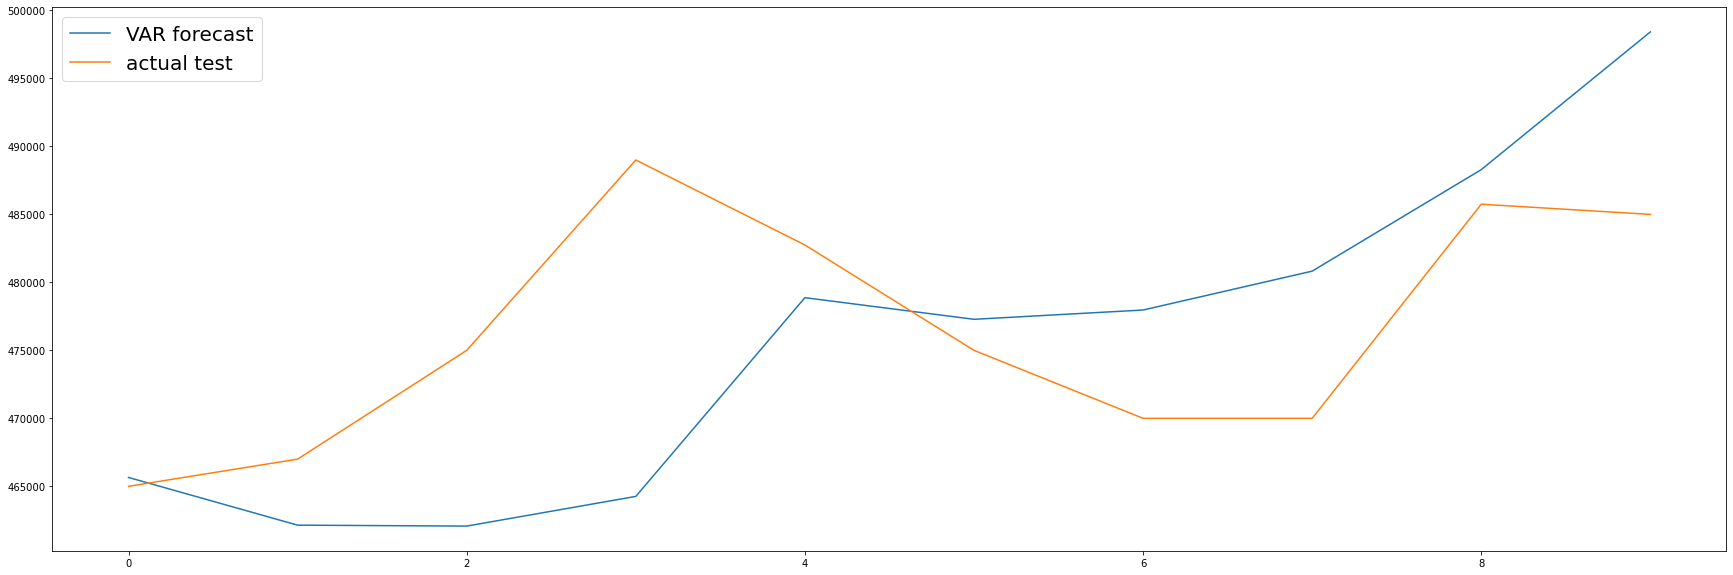

In [807]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'], label='VAR forecast')
plt.plot(np.array(test_final['MedianSoldPrice_AllHomes.California']), label='actual test')
plt.legend(loc='upper left', fontsize=20)
plt.show()

## Test Set

In [655]:
df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]
df_train.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [656]:
df_test=pd.read_csv("data/test.csv")

In [657]:
test_final= pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])['2016-01-31':]

In [658]:
test_final['MedianSoldPrice_AllHomes.California']=np.array(df_test['Median House Price'])

In [659]:
test_final

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2016-01-31,476250,3.91,5.0
2016-02-29,466000,3.96,4.9
2016-03-31,485000,3.60,5.0
2016-04-30,501000,3.60,5.0
2016-05-31,501000,3.59,4.8
2016-06-30,505000,3.59,4.8
2016-07-31,507000,3.46,4.9
2016-08-31,510000,3.46,4.8
2016-09-30,510000,3.42,5.0


In [660]:
dftest1 = adfuller(df_train['MedianSoldPrice_AllHomes.California'], autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(df_train['MedianMortageRate'], autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(df_train['UnemploymentRate'], autolag='AIC')
dfoutput3 = pd.Series(dftest3[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64
Test Statistic   -1.822848
p-value           0.369179
dtype: float64
Test Statistic   -1.481369
p-value           0.542707
dtype: float64


## Testing for Granger's Causality Test

In [661]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'

In [662]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df    

In [663]:
grangers_causation_matrix(df_train, variables = df_train.columns)  

,MedianSoldPrice_AllHomes.California_x,MedianMortageRate_x,UnemploymentRate_x
MedianSoldPrice_AllHomes.California_y,1.0000,0.0,0.0000
MedianMortageRate_y,0.0619,1.0,0.0803
UnemploymentRate_y,0.0000,0.0,1.0000


### Maybe after differencing the values there will be more causality? 
### Conclusion: There is causality since p value <0.05

In [664]:
train=df_train.diff().diff().dropna()

In [665]:
grangers_causation_matrix(train, variables = train.columns)  

,MedianSoldPrice_AllHomes.California_x,MedianMortageRate_x,UnemploymentRate_x
MedianSoldPrice_AllHomes.California_y,1.0000,0.0000,0.0000
MedianMortageRate_y,0.0052,1.0000,0.0347
UnemploymentRate_y,0.0000,0.0003,1.0000


In [666]:
dt_diff=train

In [667]:
dftest1 = adfuller(dt_diff['MedianSoldPrice_AllHomes.California'], autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(dt_diff['MedianMortageRate'], autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(dt_diff['UnemploymentRate'], autolag='AIC')
dfoutput3 = pd.Series(dftest3[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -7.390432e+00
p-value           8.027576e-11
dtype: float64
Test Statistic   -5.442476
p-value           0.000003
dtype: float64
Test Statistic   -1.249864e+01
p-value           2.838908e-23
dtype: float64


In [668]:
standard_scaler=MinMaxScaler(feature_range=(0,1))
standard_scaler.fit(dt_diff)
dt_standard=standard_scaler.transform(dt_diff)

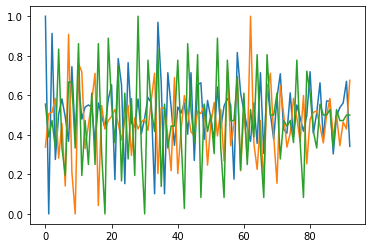

In [669]:
plt.plot(dt_standard)

In [670]:
# model fitting on the differenced data, auto choose AR order
from statsmodels.tsa.api import VAR
model = VAR(dt_standard)
model_select = model.select_order(maxlags=15)
model_select.summary()

,AIC,BIC,FPE,HQIC
0,-10.29,-10.20,3.397e-05,-10.25
1,-10.94,-10.58,1.776e-05,-10.79
2,-11.67,-11.04*,8.530e-06,-11.42
3,-11.78,-10.88,7.671e-06,-11.42
4,-12.13,-10.95,5.432e-06,-11.66
5,-12.37,-10.92,4.329e-06,-11.79
6,-12.58,-10.85,3.562e-06,-11.89
7,-12.57,-10.58,3.637e-06,-11.77
8,-12.91,-10.65,2.641e-06,-12.01
9,-12.82,-10.29,2.981e-06,-11.81


In [671]:
var_model=model.fit(maxlags=15,ic='fpe')
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Mar, 2021
Time:                     16:14:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.5787
Nobs:                     82.0000    HQIC:                  -12.3705
Log likelihood:           309.411    FPE:                1.49545e-06
AIC:                     -13.5724    Det(Omega_mle):     5.28251e-07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          2.728931         1.020681            2.674           0.008
L1.y1         -0.733386         0.135455           -5.414           0.000
L1.y2         -0.043160         0.091573           -0.471           0.637
L1.y3          0.

### Check the lag order in the model

In [672]:
lag_order = var_model.k_ar
print(lag_order)

11


### Forecast using chosen Var Model

In [673]:
pred = var_model.forecast(var_model.y, steps=len(test))

In [674]:
#dt_forecast=standard_scaler.inverse_transform(pred)
dt_forecast = pd.DataFrame(pred, columns=['MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate'])

In [675]:
dt_forecast

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,0.457378,0.517743,0.397050
1,0.618776,0.256084,0.466173
2,0.664020,0.425749,0.529230
3,0.319671,0.542698,0.418277
4,0.495196,0.414545,0.461085
5,0.538860,0.392682,0.445602
6,0.474953,0.581906,0.481560
7,0.540499,0.420147,0.592510
8,0.540099,0.404007,0.410416
9,0.460794,0.508899,0.403349


In [676]:
dt_forecast=standard_scaler.inverse_transform(dt_forecast)

In [677]:
dt_forecast=pd.DataFrame(dt_forecast, columns=df_train.columns + '_2d')

In [678]:
dt_forecast

,MedianSoldPrice_AllHomes.California_2d,MedianMortageRate_2d,UnemploymentRate_2d
0,-5176.972757,0.085196,-0.270620
1,10640.011267,-0.286361,-0.021778
2,15073.990943,-0.045436,0.205227
3,-18672.237554,0.120631,-0.194202
4,-1470.753247,-0.061345,-0.040095
5,2808.318728,-0.092391,-0.095834
6,-3454.571569,0.176307,0.033616
7,2968.919382,-0.053392,0.433036
8,2929.735206,-0.076311,-0.222501
9,-4842.147285,0.072637,-0.247944


In [679]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [680]:
df_train.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [681]:
dt_forecast_inv=invert_transformation(df_train,dt_forecast,second_diff=True)

In [682]:
dt_forecast_inv

,MedianSoldPrice_AllHomes.California_2d,MedianMortageRate_2d,UnemploymentRate_2d,MedianSoldPrice_AllHomes.California_1d,MedianSoldPrice_AllHomes.California_forecast,MedianMortageRate_1d,MedianMortageRate_forecast,UnemploymentRate_1d,UnemploymentRate_forecast
0,-5176.972757,0.085196,-0.270620,-5926.972757,479073.027243,0.285196,4.175196,-0.170620,4.929380
1,10640.011267,-0.286361,-0.021778,4713.038510,483786.065753,-0.001165,4.174030,-0.192398,4.736982
2,15073.990943,-0.045436,0.205227,19787.029453,503573.095206,-0.046602,4.127429,0.012829,4.749811
3,-18672.237554,0.120631,-0.194202,1114.791898,504687.887104,0.074030,4.201458,-0.181373,4.568437
4,-1470.753247,-0.061345,-0.040095,-355.961349,504331.925755,0.012684,4.214143,-0.221469,4.346969
5,2808.318728,-0.092391,-0.095834,2452.357380,506784.283135,-0.079707,4.134436,-0.317302,4.029666
6,-3454.571569,0.176307,0.033616,-1002.214190,505782.068945,0.096600,4.231037,-0.283686,3.745980
7,2968.919382,-0.053392,0.433036,1966.705192,507748.774137,0.043209,4.274245,0.149349,3.895329
8,2929.735206,-0.076311,-0.222501,4896.440398,512645.214535,-0.033102,4.241143,-0.073151,3.822177
9,-4842.147285,0.072637,-0.247944,54.293113,512699.507648,0.039535,4.280678,-0.321095,3.501082


In [683]:
test_final['MedianSoldPrice_AllHomes.California']

Date
2016-01-31    476250
2016-02-29    466000
2016-03-31    485000
2016-04-30    501000
2016-05-31    501000
2016-06-30    505000
2016-07-31    507000
2016-08-31    510000
2016-09-30    510000
2016-10-31    523000
2016-11-30    506000
2016-12-31    510000
Name: MedianSoldPrice_AllHomes.California, dtype: int64

In [684]:
MAPE_VAR=mean_absolute_error(test_final['MedianSoldPrice_AllHomes.California'],dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'])

In [685]:
print("MAPE of the VAR Multivariate model is:",MAPE_VAR)

MAPE of the VAR Multivariate model is: 0.013998163840859855


In [686]:
mean_squared_error(test_final['MedianSoldPrice_AllHomes.California'],dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'],squared=False)

9109.961905123782

In [846]:
def plot_hist_pred(history, test, pred):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    time = [history['MedianSoldPrice_AllHomes.California'], history['MedianSoldPrice_AllHomes.California']['2012-10-01':]]
    titles = ['2008-2016', '2013-2016']
    for i in range(2):
        ax[i].plot(time[i], label='Historic prices')
        ax[i].plot(test['MedianSoldPrice_AllHomes.California'],label='Actual prices')
        ax[i].plot(test['pred_price'],label='Predicted prices')
        ax[i].legend(loc='upper left', fontsize=8)
        ax[i].set_title(titles[i])
    plt.tight_layout()
        

In [847]:
preds = dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'].tolist()
test_final['pred_price'] = preds

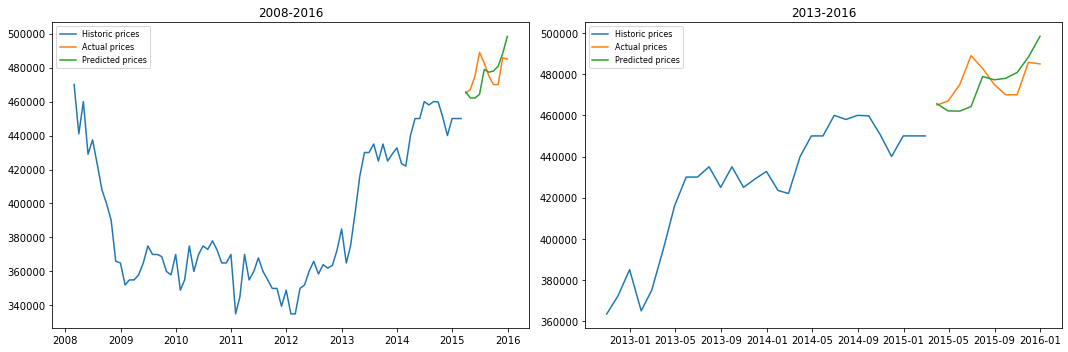

In [848]:
plot_hist_pred(df_train, test_final,'MedianSoldPrice_AllHomes.California')

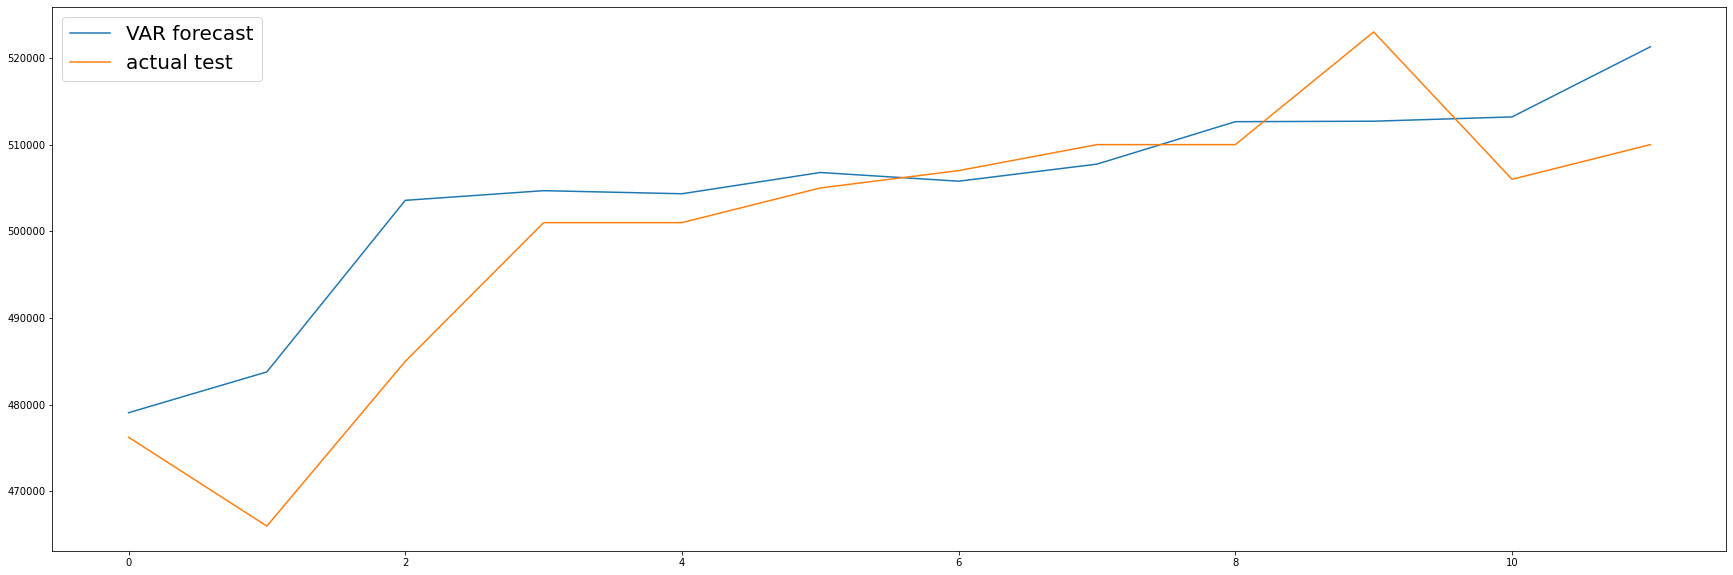

In [687]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(dt_forecast_inv['MedianSoldPrice_AllHomes.California_forecast'], label='VAR forecast')
plt.plot(np.array(test_final['MedianSoldPrice_AllHomes.California']), label='actual test')
plt.legend(loc='upper left', fontsize=20)
plt.show()

### 3.1 SARIMAX Multivariate

In [849]:
df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]

In [850]:
train_size = int(len(df_train.iloc[:,0]) * 0.90)
df_train, test_final = df_train[0:train_size], df_train[train_size:]

In [851]:
#sarimax 
#drop na and normalize the features X for better prediction
dt=df_train[['MedianMortageRate','UnemploymentRate']].dropna()
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dt)
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
X.rename(columns={ 0:'Mortgage', 1:'Unemp'}, inplace=True)
X.head()

,Mortgage,Unemp
0,0.729927,0.200000
1,0.784672,0.171429
2,0.777372,0.228571
3,0.795620,0.200000
4,0.843066,0.171429


### Scaling the endogenous variable Median price values

In [852]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(df_train[['MedianSoldPrice_AllHomes.California']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [861]:
from pmdarima.arima import auto_arima

### Fitting the best model

In [862]:
#SARIMAX order selection
step_wise=auto_arima(y, 
     exogenous= X[['Mortgage','Unemp']],
     information_criterion='bic',
     seasonal=True,
    m=12,
    max_d=2,
    max_D=1,
    stepwise=True,
    trace=True,
    error_action='ignore'
    )

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-170.109, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-156.703, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-173.473, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-169.788, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-161.077, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-154.252, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=-169.130, Time=1.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=-169.149, Time=0.81 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-170.611, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=-164.696, Time=1.32 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-174.687, Time=0.31 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : BIC=-170.655, Time=0.60 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=-170.680, Time=0.85 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=-172.359, Time=0.27 sec
 ARIMA(0,1,0)(2,0,1

In [863]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(endog=y, exog= X[['Mortgage','Unemp']], order=(0,1,0),seasonal_order=(1,0,0,12), enforce_invertibility=False, enforce_stationarity=False)

In [864]:
test_scaled=sc_in.transform(test_final[['MedianMortageRate','UnemploymentRate']])

In [865]:
results= model.fit()
forecast= results.forecast(steps=len(test_final), exog=test_scaled)
forecast

85    0.907159
86    0.948770
87    0.950825
88    0.975827
89    0.967152
90    0.963938
91    0.962975
92    0.948194
93    0.918139
94    0.934745
Name: predicted_mean, dtype: float64

In [866]:
testPredict = sc_out.inverse_transform(np.array(forecast).reshape(-1,1))
pred=pd.DataFrame(testPredict)

In [867]:
MAPE_SARIMAX=mean_absolute_error(test_final['MedianSoldPrice_AllHomes.California'],pred)

In [868]:
print("MAPE of the SARIMAX Multivariate model is:",MAPE_SARIMAX)

MAPE of the SARIMAX Multivariate model is: 0.0281569091445678


In [869]:
mean_squared_error(test_final['MedianSoldPrice_AllHomes.California'],pred,squared=False)

15668.394773525977

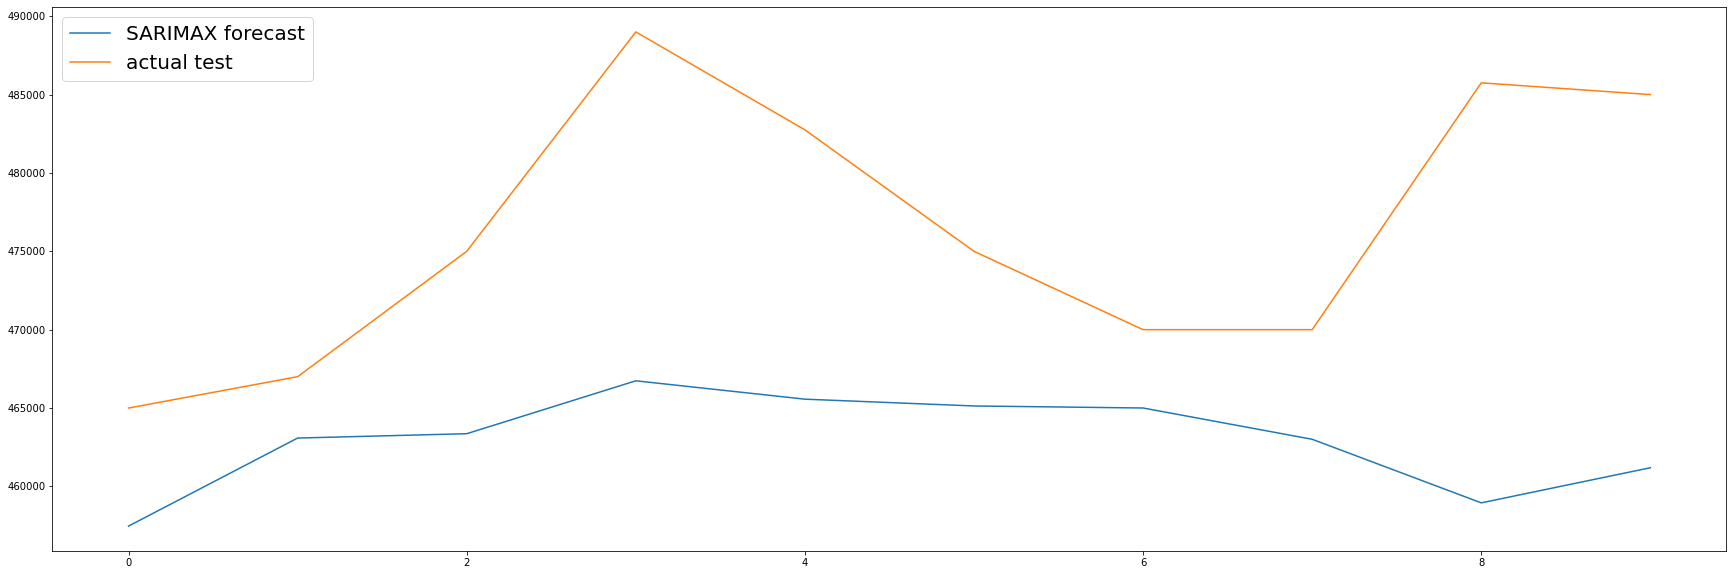

In [870]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(testPredict, label='SARIMAX forecast')
plt.plot(np.array(test_final['MedianSoldPrice_AllHomes.California']), label='actual test')
plt.legend(loc='upper left', fontsize=20)
plt.show()

## Test Set

In [871]:
df_train = pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])[:sep_date]

In [872]:
test_final= pd.read_csv("data/zillow-california.csv", index_col=["Date"], parse_dates=["Date"])['2016-01-31':]
test_final['MedianSoldPrice_AllHomes.California']=np.array(df_test['Median House Price'])

### Scaling the exogenous variables - Mortgage Rate and Unemployment Rate

In [873]:
#sarimax 
#drop na and normalize the features X for better prediction
dt=df_train[['MedianMortageRate','UnemploymentRate']].dropna()
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dt)
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
X.rename(columns={ 0:'Mortgage', 1:'Unemp'}, inplace=True)
X.head()

,Mortgage,Unemp
0,0.729927,0.317073
1,0.784672,0.292683
2,0.777372,0.341463
3,0.795620,0.317073
4,0.843066,0.292683


### Scaling the endogenous variable Median price values

In [874]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(df_train[['MedianSoldPrice_AllHomes.California']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

### Fitting the best model

In [875]:
#SARIMAX order selection
from pmdarima.arima import auto_arima
step_wise=auto_arima(y, 
     exogenous= X[['Mortgage','Unemp']],
     information_criterion='bic',
     seasonal=True,
    m=12,
    max_d=2,
    max_D=1,
    stepwise=True,
    trace=True,
    error_action='ignore'
    )

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-214.855, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-205.539, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-223.029, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-217.981, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-210.072, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-202.516, Time=0.23 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=-218.516, Time=1.11 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=-218.529, Time=0.75 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-218.468, Time=0.56 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=-214.022, Time=1.20 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-224.859, Time=0.30 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : BIC=-220.360, Time=0.72 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=-220.372, Time=0.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=-221.245, Time=0.26 sec
 ARIMA(0,1,0)(2,0,1

In [876]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(endog=y, exog= X[['Mortgage','Unemp']], order=(0,1,0),seasonal_order=(1,0,0,12), enforce_invertibility=False, enforce_stationarity=False)

In [877]:
test_scaled=sc_in.transform(test_final[['MedianMortageRate','UnemploymentRate']])

In [878]:
results= model.fit()
forecast= results.forecast(steps=len(test_final), exog=test_scaled)
forecast

95     0.969563
96     0.970374
97     1.037751
98     1.041515
99     1.059261
100    1.100439
101    1.095148
102    1.073670
103    1.064823
104    1.067373
105    1.099520
106    1.066092
Name: predicted_mean, dtype: float64

In [879]:
testPredict = sc_out.inverse_transform(np.array(forecast).reshape(-1,1))
pred=pd.DataFrame(testPredict)

In [880]:
MAPE_SARIMAX=mean_absolute_error(test_final['MedianSoldPrice_AllHomes.California'],pred)

In [881]:
print("MAPE of the SARIMAX Multivariate model is:",MAPE_SARIMAX)

MAPE of the SARIMAX Multivariate model is: 0.02781755811975298


In [882]:
mean_squared_error(test_final['MedianSoldPrice_AllHomes.California'],pred,squared=False)

10973.732726314835

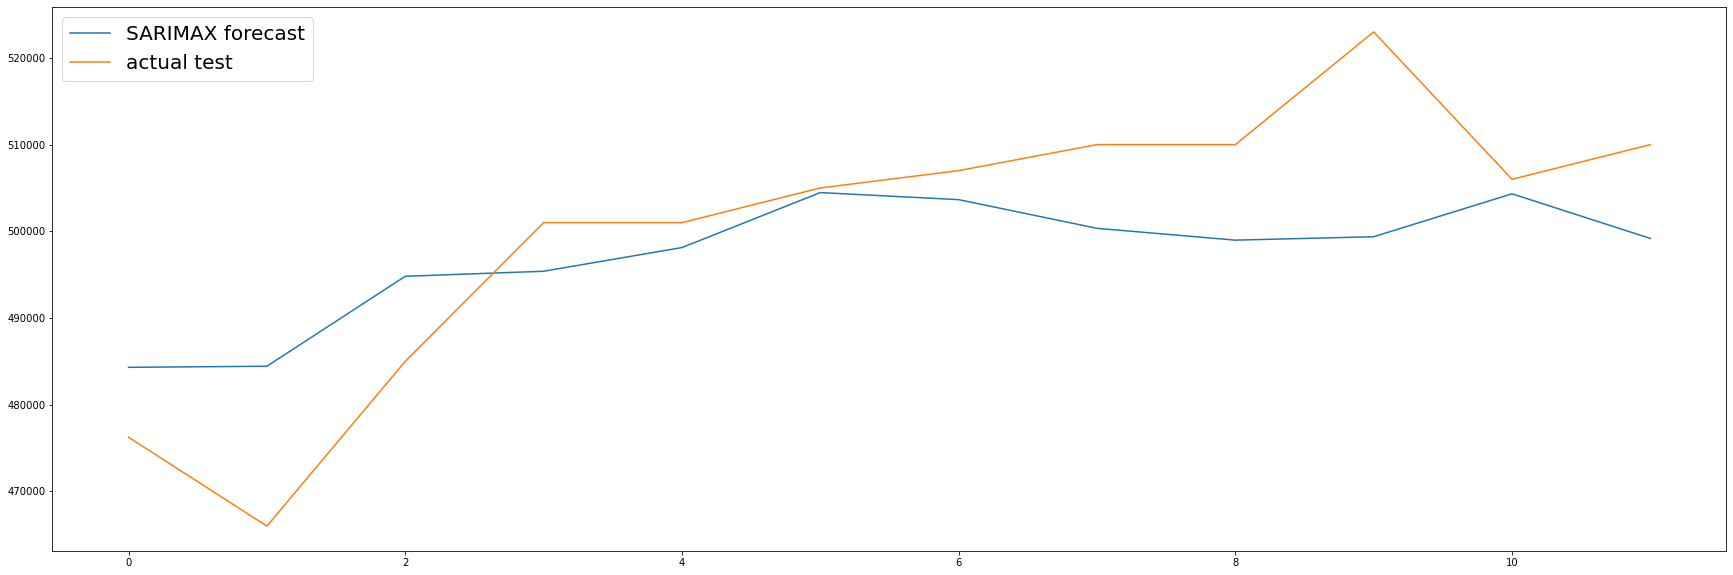

In [883]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(testPredict, label='SARIMAX forecast')
plt.plot(np.array(test_final['MedianSoldPrice_AllHomes.California']), label='actual test')
plt.legend(loc='upper left', fontsize=20)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0aaa1fc-5db0-4bb5-b9fc-a59427928618' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
# from LSTM import *

In [2]:
from torch.utils.data import TensorDataset, DataLoader

## Load data and MinMax scale

In [3]:
multi_df = pd.read_csv('data/df_train_multi_cols.csv', index_col=['Date'], parse_dates=['Date'])
multi_df.columns = ['price','mortgage','unemployment']

In [4]:
multi_df.head()

,price,mortgage,unemployment
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
multi_data_normalized = scaler.fit_transform(multi_df.values.reshape(-1, 3))

In [6]:
multi_data_normalized[:5]

array([[ 0.75324675,  0.45985401, -0.36585366],
       [ 0.37662338,  0.56934307, -0.41463415],
       [ 0.62337662,  0.55474453, -0.31707317],
       [ 0.22077922,  0.59124088, -0.36585366],
       [ 0.33116883,  0.68613139, -0.41463415]])

## Create Time Series Dataset for LSTM

In [7]:
def to_multivar_timeseries(data, window, y_index=0):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i: i+window])
        y.append(data[i+window, y_index])
    return np.array(X).astype("float64"), np.array(y).astype("float64")

In [149]:
window_size = 5
X, y = to_multivar_timeseries(multi_data_normalized, window_size)

## Train-Valid split

In [150]:
valid_data_size = 18
X_train, X_valid = X[:-valid_data_size], X[-valid_data_size:]
y_train, y_valid = y[:-valid_data_size], y[-valid_data_size:]

In [151]:
train_tensor = TensorDataset(torch.from_numpy(X_train).double(), torch.from_numpy(y_train).double())
valid_tensor = TensorDataset(torch.from_numpy(X_valid).double(), torch.from_numpy(y_valid).double())

In [152]:
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=1, drop_last=True)
valid_loader = DataLoader(valid_tensor, shuffle=False, batch_size=1, drop_last=True)

## Define LSTM Model

In [153]:
class LSTM(nn.Module):
    
    # constructor
    def __init__(self, input_size, hidden_size, num_lstm_layers, bidirectional):
        super().__init__()
        
        # input previous prices. there are "window"s of previous prices
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.predict = nn.Linear(hidden_size, 1)
        
        pass
    
    def forward(self, inputs):
        # inputs = inputs.float()
        
        out = None
        out, _ = self.lstm(inputs.float())
        out, _ = torch.max(out, dim=1)
        out = self.predict(out)
        
        return out

In [300]:
model = LSTM(input_size=3, hidden_size=20, num_lstm_layers=1, bidirectional=False)

In [301]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [302]:
model.to(device)

LSTM(
  (lstm): LSTM(3, 20, batch_first=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)

In [303]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the Model

In [304]:
import tqdm

In [305]:
class Learner():
    # constructor
    def __init__(self,  model, criterion, optimizer):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
       
        
    def train(self, train_loader, val_loader, device, num_epochs):
        
        train_loss_history = []
        val_loss_history = []
        
        min_loss = np.Infinity
        for epoch in tqdm.tqdm_notebook(range(num_epochs)):
            self.model.train()

            for i, (data_batch, target_batch) in enumerate(train_loader):
                preds = self.model(data_batch.to(device))
                train_loss = self.criterion(preds.double(), target_batch.double().to(device))
                train_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss_history.append(train_loss.item())
            
            batch_min_loss = np.Infinity
            for i, (data_batch, target_batch) in enumerate(val_loader):
                preds = self.model(data_batch.to(device))
                val_loss = self.criterion(preds, target_batch.to(device))
                optimizer.zero_grad()
                val_loss_history.append(val_loss.item())
                
                if val_loss < batch_min_loss:
                    batch_min_loss = val_loss
            
            if batch_min_loss < min_loss:
                min_loss = batch_min_loss
                torch.save(model.state_dict(), 'best_model.pt')
                
            print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {val_loss}")
        
        return train_loss_history, val_loss_history
    
    def do_test(self, test_loader, device, best_model=None):
        if best_model == None:
            best_model = self.model
            
        real_data = []
        pred_data = []
        for i, (data_batch, target_batch) in enumerate(test_loader):
            preds = best_model(data_batch.to(device))
            test_loss = self.criterion(preds, target_batch.to(device))
            optimizer.zero_grad()

            for i in range(len(target_batch)):
                real_data.append(target_batch.__getitem__(i).item())
                pred_data.append(preds.__getitem__(i).item())
        
        return real_data, pred_data

In [306]:
NUM_EPOCHS = 20
learner = Learner(model, loss_function, optimizer)

In [307]:
train_loss_history, valid_loss_history = learner.train(train_loader, valid_loader, device, NUM_EPOCHS)

/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train_loss: 0.8560885172145261, valid_loss: 1.403000848834909
Epoch: 1, train_loss: 0.8534030942726186, valid_loss: 1.2778206465922917
Epoch: 2, train_loss: 0.7644358549838294, valid_loss: 1.140347757793816
Epoch: 3, train_loss: 0.6759027273176669, valid_loss: 1.0050689351548945
Epoch: 4, train_loss: 0.6073828428593799, valid_loss: 0.887536223040865
Epoch: 5, train_loss: 0.5493849182462027, valid_loss: 0.7852914385470048
Epoch: 6, train_loss: 0.4932540139752362, valid_loss: 0.6887396494488576
Epoch: 7, train_loss: 0.43645612948126067, valid_loss: 0.5860803641778446
Epoch: 8, train_loss: 0.37576025671904356, valid_loss: 0.46501721758805104
Epoch: 9, train_loss: 0.30197552371460307, valid_loss: 0.3159707630503262
Epoch: 10, train_loss: 0.2198584161861121, valid_loss: 0.17311196584284025
Epoch: 11, train_loss: 0.16844661999213006, valid_loss: 0.10112372037488249
Epoch: 12, train_loss: 0.14910197403517902, valid_loss: 0.08547909009103595
Epoch: 13, train_loss: 0.14543486614481196

In [308]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

## Load test data

In [309]:
df = pd.read_csv("data/zillow-california.csv", index_col=['Date'], parse_dates=['Date'])
df.columns = ['price','mortgage','unemployment']

df_test = df["2016-01-31":]

In [310]:
# test_normalized = scaler.transform(df_test.values.reshape(-1, 3))
# df_test_normalized

In [311]:
df_test_init = multi_df[-window_size:]

In [312]:
df_test_concat = pd.concat([df_test_init, df_test])

In [313]:
df_test_concat

,price,mortgage,unemployment
Date,,,
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1
2016-01-31,NaN,3.91,5.0
2016-02-29,NaN,3.96,4.9
2016-03-31,NaN,3.60,5.0
2016-04-30,NaN,3.60,5.0


In [314]:
for i in range(len(df_test_concat)-window_size):
    df_tmp = df_test_concat.iloc[i:i+window_size]
    data = scaler.transform(df_tmp.values.reshape(-1, 3))
    
    X_test = np.array([data[0: window_size]])
    y_test = np.array([0]) # no need, it simply to create a dataloader
    
    
    
    test_tensor = TensorDataset(torch.from_numpy(X_test).double(), torch.from_numpy(y_test).double())
    test_loader = DataLoader(test_tensor, shuffle=False, batch_size=1, drop_last=False)
    
    X_tmp, _ = next(iter(test_loader))
    pred = model(X_tmp).data.tolist()[0][0]
    
    list_tmp = np.array([pred, 0, 0]).reshape(-1, 3) # 0 is tmp to fit the shape
    real_pred = scaler.inverse_transform(list_tmp)[0][0]
    
    
    df_test_concat.iloc[i+window_size, 0] = real_pred
    print(real_pred)

461425.4878759384
461808.89493227005
462609.0705394745
464437.1372461319
462681.1770796776
460942.0376420021
461311.9330406189
463655.1775932312
463907.9199433327
464606.781065464
464597.2623229027
465199.4398236275


In [315]:
df_test_concat

,price,mortgage,unemployment
Date,,,
2015-08-31,475000.000000,3.95,5.2
2015-09-30,470000.000000,3.87,5.1
2015-10-31,470000.000000,3.80,5.0
2015-11-30,485750.000000,3.69,5.0
2015-12-31,485000.000000,3.89,5.1
2016-01-31,461425.487876,3.91,5.0
2016-02-29,461808.894932,3.96,4.9
2016-03-31,462609.070539,3.60,5.0
2016-04-30,464437.137246,3.60,5.0


## Load real test data

In [316]:
df_real_test = pd.read_csv("data/test.csv", index_col=['Month'], parse_dates=['Month'])

In [317]:
real_pred_data = df_real_test["Median House Price"].values

In [318]:
df_pred = df_test_concat["2016-01-31":]

In [319]:
pred_data = df_pred["price"].values

In [320]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [321]:
mape = mean_absolute_percentage_error(real_pred_data, pred_data)

In [322]:
print(f"MAPE of LSTM is {mape}")

MAPE of LSTM is 0.07297315585947449


In [323]:
mse = mean_squared_error(real_pred_data, pred_data)

In [324]:
print(f"MSE of LSTM is {mse}")

MSE of LSTM is 1581310931.7141192


In [325]:
mae = mean_absolute_error(real_pred_data, pred_data)

In [326]:
print(f"MAE of LSTM is {mae}")

MAE of LSTM is 36922.306741277374


## Plot

In [327]:
import matplotlib.pyplot as plt

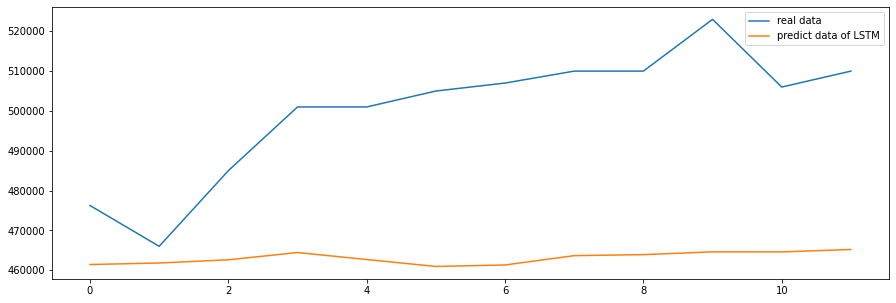

In [328]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(real_pred_data, label="real data")
ax.plot(pred_data, label="predict data of LSTM")
ax.legend()
plt.show()